In [1]:
# Install necessary libraries
!pip install geopandas rasterio gdal earthengine-api geemap matplotlib numpy folium scikit-learn requests twilio bs4 zipfile36 shapely ipywidgets ipyleaflet


In [1]:
# Import necessary libraries
import ee
import geemap
import os

# Authenticate Earth Engine access
try:
    ee.Initialize()
except Exception as e:
        print(f"Earth Engine initialization failed: {e}")
        print("Attempting to authenticate...")
        ee.Authenticate()
        ee.Initialize()

# Create interactive map object
Map = geemap.Map()

# Load GMA FeatureCollection
gmas = ee.FeatureCollection("projects/ee-ongetewesly1/assets/bangweulu_gma")

# Inspect attribute table to get correct field for geometries within the collection
# Get the first feature in the collection
first_feature = gmas.first()

# Get the list of property keys
property_keys = first_feature.propertyNames().getInfo()

print("Available attribute fields:", property_keys)

# Get all unique 'Name' attributes
aoi_names = gmas.aggregate_array('NAME').getInfo() # use correct attribute field to fetch geometries

# Use an index to select an AOI (change `index` to process different AOIs)
index = 0  # Adjust this index for the AOI you want to process
gma_name = aoi_names[index]
gma = gmas.filter(ee.Filter.eq('NAME', gma_name))

# Visualize AOI on the map
Map.centerObject(gma, 9)
Map.addLayer(gma.style(**{'color': 'black', 'fillColor': '00000000'}), {}, gma_name)

print(f"AOI '{gma_name}' loaded and added to the map.")

# Export AOI as a shapefile to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=gma,
    description=f"{gma_name}",
    fileFormat='SHP',
    folder='AOI'
)
task.start()

print(f"Export task for AOI '{gma_name}' started.")
Map


Available attribute fields: ['WDPAID', 'REP_AREA', 'OWN_TYPE', 'REP_M_AREA', 'INT_CRIT', 'GOV_TYPE', 'ISO3', 'GIS_AREA', 'DESIG', 'STATUS', 'NO_TAKE', 'PA_DEF', 'WDPA_PID', 'CONS_OBJ', 'MARINE', 'GIS_M_AREA', 'ORIG_NAME', 'DESIG_ENG', 'MANG_PLAN', 'SUPP_INFO', 'NAME', 'DESIG_TYPE', 'METADATAID', 'MANG_AUTH', 'STATUS_YR', 'PARENT_ISO', 'NO_TK_AREA', 'VERIF', 'IUCN_CAT', 'SUB_LOC', 'system:index']
AOI 'Bangweulu' loaded and added to the map.
Export task for AOI 'Bangweulu' started.


Map(center=[-11.926656327582394, 30.348170104317912], controls=(WidgetControl(options=['position', 'transparen…

In [2]:
# Define a function to scale NDVI values
def scale_ndvi(img):
    return img.multiply(0.0001).rename('NDVI').copyProperties(img, ['system:time_start'])

# Load, filter, and scale MODIS NDVI ImageCollection
modisNDVI = ee.ImageCollection('MODIS/006/MOD13Q1') \
    .select('NDVI') \
    .filterDate('2020-01-01', '2024-12-31') \
    .filterBounds(gma) \
    .map(scale_ndvi)

# Display a sample NDVI image clipped to the AOI
firstNDVI = modisNDVI.first()
Map.addLayer(firstNDVI.clip(gma), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Sample NDVI (First Image)')
print("MODIS NDVI loaded and sample image added to the map.")
# Map

MODIS NDVI loaded and sample image added to the map.


In [3]:
# Load Sentinel-2 Harmonized Collection
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(gma) \
    .filterDate('2024-08-01', '2025-04-25') \
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 1))

# Mosaic the Sentinel-2 images
sentinelMosaic = sentinelCollection.median().clip(gma)

# Load ESA WorldCover 2020 and 2021
esa2020 = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(gma)
esa2021 = ee.Image('ESA/WorldCover/v200/2021').select('Map').clip(gma)

# Identify stable land cover areas (unchanged between 2020 and 2021)
stableLC = esa2020.eq(esa2021)

# Mask ESA 2021 to keep only stable pixels
esa_mask = esa2021.updateMask(stableLC).rename('lc')

# Generate stable training points using stratified sampling
samplePoints = esa_mask.stratifiedSample(
  numPoints=500,
  classBand='lc',
  region=gma.geometry(),
  scale=10,
  tileScale=8,
  geometries=True
)

# Define bands for classification
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']

# Sample Sentinel-2 reflectance values at training point locations
trainingData = sentinelMosaic.select(bands).sampleRegions(
  collection=samplePoints,
  properties=['lc'],
  scale=10,
  tileScale=8
)

# Train Classifier and Classify
classifier = ee.Classifier.smileRandomForest(50).train(
  features=trainingData,
  classProperty='lc',
  inputProperties=bands
)

land_cover = sentinelMosaic.select(bands).classify(classifier).rename('lc')

# Visualize Classified Image
landCoverLegend = [
  {'value': 10, 'name': 'Tree cover', 'color': '006400'},
  {'value': 20, 'name': 'Shrubland', 'color': 'ffbb22'},
  {'value': 30, 'name': 'Grassland', 'color': 'ffff4c'},
  {'value': 40, 'name': 'Cropland', 'color': 'f096ff'},
  {'value': 50, 'name': 'Built-up', 'color': 'fa0000'},
  {'value': 60, 'name': 'Bare / sparse vegetation', 'color': 'b4b4b4'},
  {'value': 70, 'name': 'Snow and ice', 'color': 'f0f0f0'},
  {'value': 80, 'name': 'Permanent water bodies', 'color': '003df5'},
  {'value': 90, 'name': 'Herbaceous wetland', 'color': '0096a0'},
  {'value': 95, 'name': 'Mangroves', 'color': '00cf75'},
  {'value': 100, 'name': 'Moss and lichen', 'color': 'fae6a0'}
]

palette = [d['color'] for d in landCoverLegend]

# Optional geemap visualization
Map.addLayer(land_cover, {'min': 10, 'max': 100, 'palette': palette}, 'Land Cover')
# Map

In [4]:
# Define the range of years
years = ee.List.sequence(2020, 2024)

# Function to calculate yearly NDVI amplitude
def calculate_yearly_amplitude(year):
    ndvi = modisNDVI.filter(ee.Filter.calendarRange(year, year, 'year'))
    max_ndvi = ndvi.max()
    min_ndvi = ndvi.min()
    return max_ndvi.subtract(min_ndvi).set('year', year)

# Apply the function across all years
ndviYearly = ee.ImageCollection(years.map(calculate_yearly_amplitude))

# Calculate Mean NDVI Amplitude over the entire period
ndviAmpMean = ndviYearly.mean().rename('NDVI_amp')

# Calculate Mean NDVI over the entire period
ndviMean = modisNDVI.mean().rename('NDVI_mean')


# --- Optional: Print summary stats (can be slow due to getInfo()) ---

print("Calculating NDVI Amplitude Min/Max...")
ndviAmpStats = ndviAmpMean.reduceRegion(
     reducer=ee.Reducer.minMax(),
     geometry=gma.geometry(),
     scale=250, # Use appropriate scale
     maxPixels=1e13
 ).getInfo()
print('NDVI Amplitude Min and Max:', ndviAmpStats)



print("\nCalculating NDVI Mean Min/Max...")
ndviMeanStats = ndviMean.reduceRegion(
     reducer=ee.Reducer.minMax(),
     geometry=gma.geometry(),
     scale=250, # Use appropriate scale
     maxPixels=1e13
 ).getInfo()
print('NDVI Mean Min and Max:', ndviMeanStats)
# --- End Optional Stats ---



# Visualize results on map, min and max based on computed stats 
Map.addLayer(ndviAmpMean.clip(gma), {
    'min': 0.13, 
    'max': 0.84, 
    'palette': ['white', 'yellow', 'orange', 'red']
},  'Mean NDVI Amplitude (2020–2024)')

Map.addLayer(ndviMean.clip(gma), { 
    'min': 0.15, 
    'max': 0.83, 
    'palette': ['brown', 'lightgreen', 'green']
},  'Mean NDVI (2020–2024)')

print("NDVI Amplitude and Mean calculated and added to the map.")

Calculating NDVI Amplitude Min/Max...
NDVI Amplitude Min and Max: {'NDVI_amp_max': 0.830775, 'NDVI_amp_min': 0.13765}

Calculating NDVI Mean Min/Max...
NDVI Mean Min and Max: {'NDVI_mean_max': 0.8259597222222225, 'NDVI_mean_min': 0.15479444444444443}
NDVI Amplitude and Mean calculated and added to the map.


In [5]:
# Water bodies mask (class 80 from ESA WorldCover)
water = land_cover.eq(80).rename('Water')

# Human activity mask (cropland, built-up, bare land)
human = land_cover.eq(40) \
    .Or(land_cover.eq(50)) \
    .Or(land_cover.eq(60)) \
    .rename('Human')

# Evergreen vegetation mask (low NDVI fluctuation + high NDVI mean)
evergreen = ndviAmpMean.lt(0.25) \
    .And(ndviMean.gt(0.5)) \
    .clip(gma) \
    .rename('Evergreen')

# Wetlands mask (class 90 from ESA WorldCover)
wetlands = land_cover.eq(90).rename('Wetlands')

# Visualize all masks
Map.addLayer(water.selfMask(), {'palette': 'blue'}, 'Water Bodies')
Map.addLayer(human.selfMask(), {'palette': 'red'}, 'Human Activity')
Map.addLayer(evergreen.selfMask(), {'palette': 'darkgreen'}, 'Evergreen Vegetation')
Map.addLayer(wetlands.selfMask(), {'palette': 'cyan'}, 'Wetlands')

print("Land cover masks created and visualized.")


# Optional: Print Pixel Counts for Verification (can be slow)

print("\nCalculating Pixel Counts...")
masks = ee.Image.cat([water, human, evergreen, wetlands])
maskStats = masks.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=gma.geometry(),
    scale=10,
    maxPixels=1e13
).getInfo()

print('Pixel Counts for Each Land Cover Mask:', maskStats)
# --- End Optional Stats ---


Land cover masks created and visualized.

Calculating Pixel Counts...
Pixel Counts for Each Land Cover Mask: {'Evergreen': 691693.2470588236, 'Human': 2798904.1607843135, 'Water': 1038760.6117647062, 'Wetlands': 22983457.43921569}


In [6]:
# Combine exclusion masks: water, human activity, evergreen, wetlands
exclusion = water.Or(human).Or(evergreen).Or(wetlands)

# Non-edible vegetation: inside exclusion zones
non_edible = ndviAmpMean.updateMask(exclusion).clip(gma).rename('Non-Edible')

# Edible vegetation: outside exclusion zones
edibleMask = exclusion.Not()
edible_vegetation = ndviAmpMean.updateMask(edibleMask).clip(gma).rename('Edible')


# --- Optional: Print statistics to guide visualization (can be slow) ---
# Edible Vegetation Stats
print("Calculating Edible Vegetation Stats...")
edibleStats = edible_vegetation.reduceRegion(
     reducer=ee.Reducer.minMax(),
     geometry=gma.geometry(),
     scale=250, # Scale matching NDVI amplitude calculation
     maxPixels=1e13
 ).getInfo()
print('Edible Vegetation NDVI Amplitude Stats (min/max):', edibleStats)

# Non-Edible Vegetation Stats
print("Calculating Non-Edible Vegetation Stats...")
non_edibleStats = non_edible.reduceRegion(
     reducer=ee.Reducer.minMax(),
     geometry=gma.geometry(),
     scale=250, # Scale matching NDVI amplitude calculation
     maxPixels=1e13
 ).getInfo()
print('Non-Edible Vegetation NDVI Amplitude Stats (min/max):', non_edibleStats)
# --- End Optional Stats ---


# Visualize edible vegetation, min and max based on computed stats
Map.addLayer(edible_vegetation, {
    'min': 0.19,
    'max': 0.84,
    'palette': ['white', 'yellow', 'orange', 'red']
}, 'Edible Vegetation')

# Visualize non-edible vegetation
Map.addLayer(non_edible, {
    'min': 0.13,
    'max': 0.73,
    'palette': ['gray', 'brown', 'darkred']
}, 'Non-Edible Vegetation')

print("Edible and Non-Edible vegetation layers created and visualized.")

Calculating Edible Vegetation Stats...
Edible Vegetation NDVI Amplitude Stats (min/max): {'Edible_max': 0.830775, 'Edible_min': 0.19494999999999996}
Calculating Non-Edible Vegetation Stats...
Non-Edible Vegetation NDVI Amplitude Stats (min/max): {'Non-Edible_max': 0.7258500000000001, 'Non-Edible_min': 0.13765}
Edible and Non-Edible vegetation layers created and visualized.


In [8]:
"""
# Perform SNIC segmentation on the edible vegetation
# Positional arguments: image, size, compactness, connectivity, neighborhoodSize, seeds.
snic = ee.Algorithms.Image.Segmentation.SNIC(edible_vegetation, 50, 5, 8, 256, None)

# Select 'clusters' band and mask
clusters = snic.select('clusters').rename('Cluster_ID')
clusters_masked = clusters.selfMask()

# Calculate per-cluster mean NDVI
clusterMeans = clusters_masked.addBands(edible_vegetation).reduceConnectedComponents(
    reducer=ee.Reducer.mean(),
    labelBand='Cluster_ID'
)

# Rename mean band for clarity
clusterNDVI = clusterMeans.select(['Edible'], ['mean_ndvi'])

# Merge cluster ID with mean NDVI
clustered = clusters_masked.addBands(clusterNDVI)

# Visualize random clusters
Map.addLayer(clustered.randomVisualizer(), {}, 'Edible Vegetation Clusters')

# Vectorize the clustered image
vector_clusters = clustered.reduceToVectors(
    reducer=ee.Reducer.first(),
    geometry=gma,
    scale=100,
    geometryType='polygon',
    labelProperty='Cluster_ID',
    maxPixels=1e13
)

# Export clusters as shapefile
task = ee.batch.Export.table.toDrive(
    collection=vector_clusters,
    description=f"{gma_name}_Edible_Vegetation_Clusters",
    folder="UAIs",
    fileFormat="SHP"
)
task.start()

print("SNIC segmentation applied and clustering export started.")
"""

'\n# Perform SNIC segmentation on the edible vegetation\n# Positional arguments: image, size, compactness, connectivity, neighborhoodSize, seeds.\nsnic = ee.Algorithms.Image.Segmentation.SNIC(edible_vegetation, 50, 5, 8, 256, None)\n\n# Select \'clusters\' band and mask\nclusters = snic.select(\'clusters\').rename(\'Cluster_ID\')\nclusters_masked = clusters.selfMask()\n\n# Calculate per-cluster mean NDVI\nclusterMeans = clusters_masked.addBands(edible_vegetation).reduceConnectedComponents(\n    reducer=ee.Reducer.mean(),\n    labelBand=\'Cluster_ID\'\n)\n\n# Rename mean band for clarity\nclusterNDVI = clusterMeans.select([\'Edible\'], [\'mean_ndvi\'])\n\n# Merge cluster ID with mean NDVI\nclustered = clusters_masked.addBands(clusterNDVI)\n\n# Visualize random clusters\nMap.addLayer(clustered.randomVisualizer(), {}, \'Edible Vegetation Clusters\')\n\n# Vectorize the clustered image\nvector_clusters = clustered.reduceToVectors(\n    reducer=ee.Reducer.first(),\n    geometry=gma,\n    sca

In [7]:
# Define NDVI Amplitude thresholds for UAI segmentation
intervals = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
uai_images = []
uai_labels = []

# Create UAI masks from edible vegetation layer
for i, (low, high) in enumerate(intervals):
    uai = edible_vegetation.gte(low).And(edible_vegetation.lt(high))
    uai_mask = uai.updateMask(uai).rename(f'UAI_{i+1}')
    uai_images.append(uai_mask)
    uai_labels.append(f'UAI {i+1}: [{low}, {high})')

# Combine all UAI masks into one labeled image
uai_combined = ee.Image(0)
for i, uai in enumerate(uai_images):
    uai_combined = uai_combined.where(uai, i + 1)

# Visualize segmented edible vegetation UAIs
uai_palette = ['gray', 'yellow', 'orange', 'green', 'darkgreen']
Map.addLayer(uai_combined, {'min': 1, 'max': 5, 'palette': uai_palette}, 'UAIs over Edible Vegetation')
print("Segmented UAIs over edible vegetation added to the map.")

Segmented UAIs over edible vegetation added to the map.


No NDVI band found for 2023-03-01 to 2023-04-01. Skipping.
No NDVI band found for 2023-04-01 to 2023-05-01. Skipping.
No NDVI band found for 2023-05-01 to 2023-06-01. Skipping.
No NDVI band found for 2023-06-01 to 2023-07-01. Skipping.
No NDVI band found for 2023-07-01 to 2023-08-01. Skipping.
No NDVI band found for 2023-08-01 to 2023-09-01. Skipping.
No NDVI band found for 2023-09-01 to 2023-10-01. Skipping.
No NDVI band found for 2023-10-01 to 2023-11-01. Skipping.
No NDVI band found for 2023-11-01 to 2023-12-01. Skipping.
No NDVI band found for 2023-12-01 to 2024-01-01. Skipping.
No NDVI band found for 2024-01-01 to 2024-02-01. Skipping.
No NDVI band found for 2024-02-01 to 2024-03-01. Skipping.
No NDVI band found for 2024-03-01 to 2024-04-01. Skipping.
No NDVI band found for 2024-04-01 to 2024-05-01. Skipping.
No NDVI band found for 2024-05-01 to 2024-06-01. Skipping.
No NDVI band found for 2024-06-01 to 2024-07-01. Skipping.
No NDVI band found for 2024-07-01 to 2024-08-01. Skippin

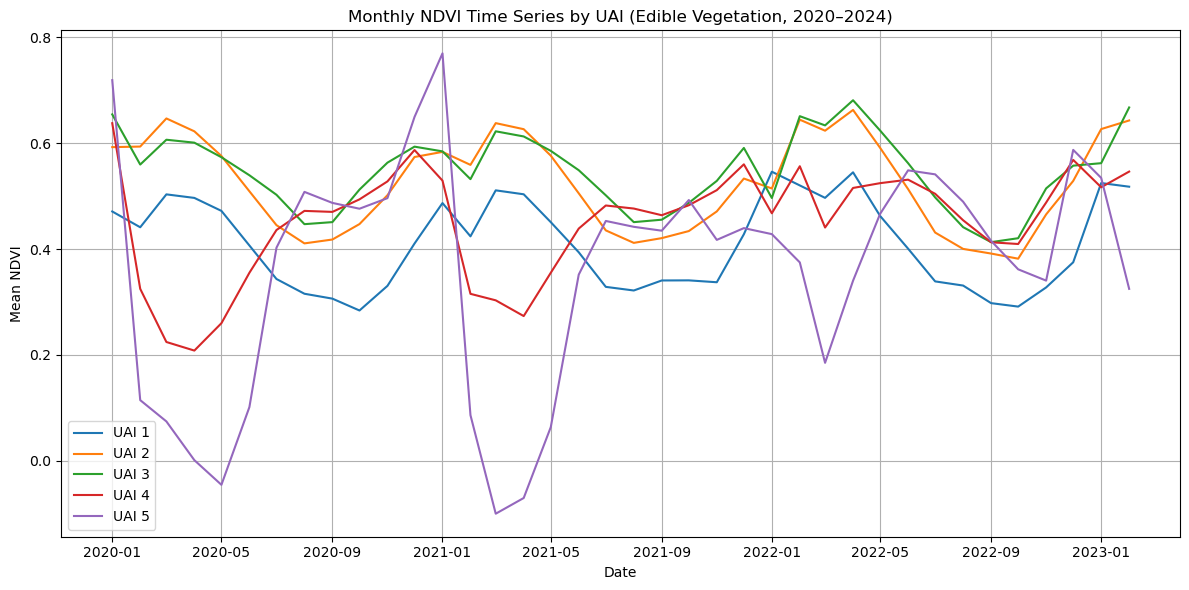

Time series CSV exported: Bangweulu_MODIS_NDVI_TimeSeries_UAIs.csv


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Define time range
months = pd.date_range('2020-01-01', '2024-12-31', freq='MS')
results = []

# Loop through each month and UAI zone
for date in months:
    start = date.strftime('%Y-%m-%d')
    end = (date + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    
    # Get monthly mean NDVI image
    monthly_coll = modisNDVI.filterDate(start, end)
    monthly_ndvi_img = monthly_coll.mean()

    # Graceful skip if no NDVI band is found
    try:
        band_names = monthly_ndvi_img.bandNames().getInfo()
        if 'NDVI' not in band_names:
            print(f"No NDVI band found for {start} to {end}. Skipping.")
            continue
    except Exception as e:
        print(f"Error checking NDVI band for {start}: {e}. Skipping.")
        continue

    # Clip and select NDVI
    monthly_ndvi = monthly_ndvi_img.select('NDVI').clip(gma)

    for i in range(5):
        zone_mask = uai_combined.eq(i + 1)
        masked_ndvi = monthly_ndvi.updateMask(zone_mask)
        
        # Reduce to mean NDVI value for the zone
        try:
            stats = masked_ndvi.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=gma.geometry(),
                scale=250,
                maxPixels=1e13
            )
            ndvi_val = stats.get('NDVI').getInfo() if stats.get('NDVI') else None
        except Exception as e:
            print(f"Error retrieving NDVI for UAI {i+1} at {start}: {e}")
            ndvi_val = None

        results.append({'Date': start, 'UAI': f'UAI {i+1}', 'NDVI': ndvi_val})

# Convert to DataFrame
df = pd.DataFrame(results)
df['Date'] = pd.to_datetime(df['Date'])

# Plot NDVI time series for each UAI
plt.figure(figsize=(12, 6))
for uai in df['UAI'].unique():
    subset = df[df['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)

plt.title('Monthly NDVI Time Series by UAI (Edible Vegetation, 2020–2024)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Export time series data to CSV
csv_path = f"{gma_name.replace(' ', '_')}_MODIS_NDVI_TimeSeries_UAIs.csv"
df.to_csv(csv_path, index=False)
print(f"Time series CSV exported: {csv_path}")

[VIIRS] No NDVI band for 2024-06-01 to 2024-07-01. Skipping.
[VIIRS] No NDVI band for 2024-07-01 to 2024-08-01. Skipping.
[VIIRS] No NDVI band for 2024-08-01 to 2024-09-01. Skipping.
[VIIRS] No NDVI band for 2024-09-01 to 2024-10-01. Skipping.
[VIIRS] No NDVI band for 2024-10-01 to 2024-11-01. Skipping.
[VIIRS] No NDVI band for 2024-11-01 to 2024-12-01. Skipping.
[VIIRS] No NDVI band for 2024-12-01 to 2025-01-01. Skipping.


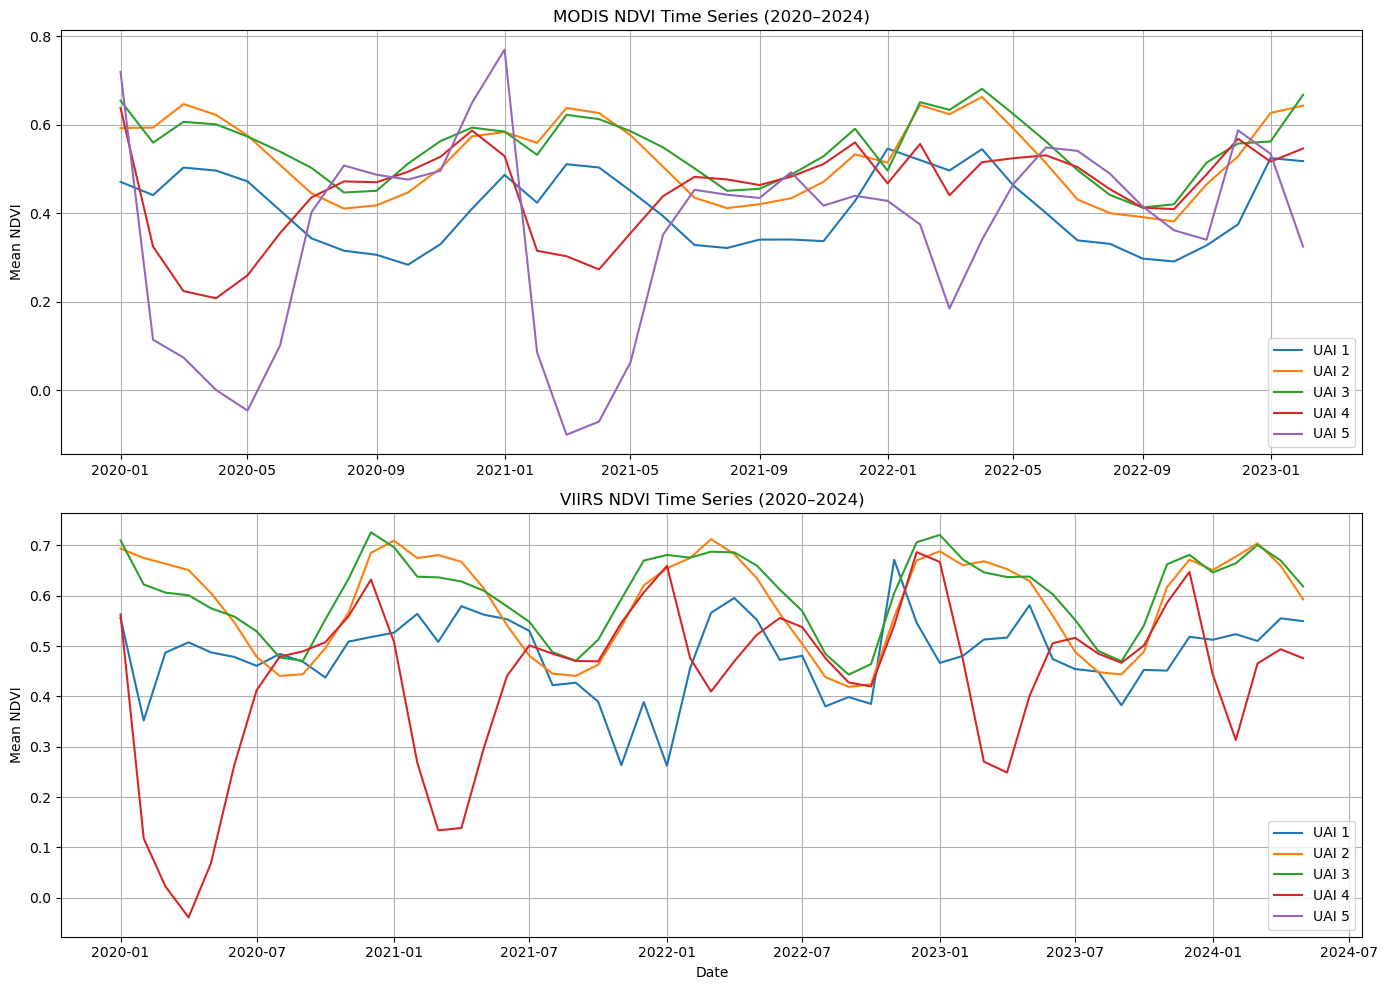

[VIIRS] Time series CSV exported: Bangweulu_VIIRS_NDVI_TimeSeries_UAIs.csv


In [9]:
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
    .filterDate('2020-01-01', '2024-12-31') \
    .filterBounds(gma) \
    .select('NDVI')

viirs_scale_factor = 0.0001

# Define time range
months = pd.date_range('2020-01-01', '2024-12-31', freq='MS')
results_viirs = []

for date in months:
    start = date.strftime('%Y-%m-%d')
    end = (date + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    
    monthly_coll = viirs.filterDate(start, end)
    monthly_ndvi_img = monthly_coll.mean()

    try:
        band_names = monthly_ndvi_img.bandNames().getInfo()
        if 'NDVI' not in band_names:
            print(f"[VIIRS] No NDVI band for {start} to {end}. Skipping.")
            continue
    except Exception as e:
        print(f"[VIIRS] Band check failed for {start}: {e}. Skipping.")
        continue

    monthly_ndvi = monthly_ndvi_img.select('NDVI').multiply(viirs_scale_factor).clip(gma)

    for i in range(5):
        zone_mask = uai_combined.eq(i + 1)
        masked_ndvi = monthly_ndvi.updateMask(zone_mask)
        
        try:
            stats = masked_ndvi.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=gma.geometry(),
                scale=500,
                maxPixels=1e13
            )
            ndvi_val = stats.get('NDVI').getInfo() if stats.get('NDVI') else None
        except Exception as e:
            print(f"[VIIRS] Error for UAI {i+1} at {start}: {e}")
            ndvi_val = None

        results_viirs.append({'Date': start, 'UAI': f'UAI {i+1}', 'NDVI': ndvi_val})

# Convert to DataFrame
df_viirs = pd.DataFrame(results_viirs)
df_viirs['Date'] = pd.to_datetime(df_viirs['Date'])

# Side-by-side MODIS vs VIIRS plots
plt.figure(figsize=(14, 10))

# MODIS
plt.subplot(2, 1, 1)
for uai in df['UAI'].unique():
    subset = df[df['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)
plt.title('MODIS NDVI Time Series (2020–2024)')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.legend()

# VIIRS
plt.subplot(2, 1, 2)
for uai in df_viirs['UAI'].unique():
    subset = df_viirs[df_viirs['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)
plt.title('VIIRS NDVI Time Series (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Export VIIRS time series to CSV
viirs_csv_path = f"{gma_name.replace(' ', '_')}_VIIRS_NDVI_TimeSeries_UAIs.csv"
df_viirs.to_csv(viirs_csv_path, index=False)
print(f"[VIIRS] Time series CSV exported: {viirs_csv_path}")

In [11]:
# Load and Aggregate External Layers

# Leaf Area Index (MODIS)
lai = ee.ImageCollection('MODIS/006/MCD15A3H') \
    .filterDate('2020-01-01', '2020-12-31') \
    .select('Lai') \
    .mean() \
    .clip(gma)

# CHIRPS Precipitation
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2020-01-01', '2020-12-31') \
    .select('precipitation') \
    .sum() \
    .clip(gma)

# SMAP Soil Moisture (surface)
soil_moisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture') \
    .filterDate('2020-01-01', '2020-12-31') \
    .select('ssm') \
    .mean() \
    .clip(gma)

Map.addLayer(lai, {'min': 0, 'max': 6, 'palette': ['white', 'green']}, 'LAI 2020')
Map.addLayer(precip, {'min': 0, 'max': 2000, 'palette': ['white', 'blue']}, 'Precipitation 2020')
Map.addLayer(soil_moisture, {'min': 0, 'max': 0.5, 'palette': ['white', 'brown']}, 'Soil Moisture 2020')

print("All additional datasets have been added.")

All additional datasets have been added.


In [20]:
# Normalize all layers (0–1)
def normalize(image, min_val, max_val):
    return image.subtract(min_val).divide(max_val - min_val).clamp(0, 1)

# Use edible_vegetation (masked amplitude values) as NDVI layer
ndvi_amp_norm = normalize(edible_vegetation, 0.1, 0.9)

# Normalization Stats
# Compute LAI stats over edible vegetation zone
laiStats = lai.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), None, True),
    geometry=gma.geometry(),
    scale=250,
    maxPixels=1e13
)
print('LAI Stats:', laiStats.getInfo())

# Compute precipitation stats over edible vegetation zone
precipStats = precip.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), None, True),
    geometry=gma.geometry(),
    scale=250,
    maxPixels=1e13
)
print('Precipitation Stats (2020):', precipStats.getInfo())

# Compute soil moisture stats over edible vegetation zone
soilStats = soil_moisture.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), None, True),
    geometry=gma.geometry(),
    scale=250,
    maxPixels=1e13
)
print('Soil Moisture Stats:', soilStats.getInfo())

# Apply stats for normalization
lai_norm = normalize(lai, 2, 20)
precip_norm = normalize(precip, 900, 1400)
soil_norm = normalize(soil_moisture, 9, 15)

# MCDA Composite (equal weight)
mcda = ndvi_amp_norm.add(lai_norm).add(precip_norm).add(soil_norm).divide(4).rename('MCDA')

Map.addLayer(mcda, {'min': 0, 'max': 1, 'palette': ['white', 'yellow', 'green']}, 'MCDA Composite (Edible Vegetation Only)')

# Segment MCDA into 5 UAI Zones (like 1.7.1)
intervals = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
mcda_images = []
mcda_labels = []

for i, (low, high) in enumerate(intervals):
    uai = mcda.gte(low).And(mcda.lt(high))
    uai_mask = uai.updateMask(uai).rename(f'MCDA_UAI_{i+1}')
    mcda_images.append(uai_mask)
    mcda_labels.append(f'MCDA UAI {i+1}: [{low}, {high})')

# Combine masks into a single MCDA UAI layer
mcda_uai = ee.Image(0)
for i, uai in enumerate(mcda_images):
    mcda_uai = mcda_uai.where(uai, i + 1)

Map.addLayer(mcda_uai, {'min': 1, 'max': 5, 'palette': ['gray', 'yellow', 'orange', 'green', 'darkgreen']}, 'MCDA UAIs')
print("MCDA-based UAIs over edible vegetation added to the map.")

LAI Stats: {'Lai_max': 48.04545454545455, 'Lai_mean': 11.607035224531668, 'Lai_min': 2.465909090909091}
Precipitation Stats (2020): {'precipitation_max': 1376.8493893097593, 'precipitation_mean': 1113.2658611353038, 'precipitation_min': 916.3182463414986}
Soil Moisture Stats: {'ssm_max': 14.47999095916748, 'ssm_mean': 10.78854798509578, 'ssm_min': 9.282564163208008}
MCDA-based UAIs over edible vegetation added to the map.


[MODIS] No NDVI band for 2023-03-01 to 2023-04-01. Skipping.
[MODIS] No NDVI band for 2023-04-01 to 2023-05-01. Skipping.
[MODIS] No NDVI band for 2023-05-01 to 2023-06-01. Skipping.
[MODIS] No NDVI band for 2023-06-01 to 2023-07-01. Skipping.
[MODIS] No NDVI band for 2023-07-01 to 2023-08-01. Skipping.
[MODIS] No NDVI band for 2023-08-01 to 2023-09-01. Skipping.
[MODIS] No NDVI band for 2023-09-01 to 2023-10-01. Skipping.
[MODIS] No NDVI band for 2023-10-01 to 2023-11-01. Skipping.
[MODIS] No NDVI band for 2023-11-01 to 2023-12-01. Skipping.
[MODIS] No NDVI band for 2023-12-01 to 2024-01-01. Skipping.
[MODIS] No NDVI band for 2024-01-01 to 2024-02-01. Skipping.
[MODIS] No NDVI band for 2024-02-01 to 2024-03-01. Skipping.
[MODIS] No NDVI band for 2024-03-01 to 2024-04-01. Skipping.
[MODIS] No NDVI band for 2024-04-01 to 2024-05-01. Skipping.
[MODIS] No NDVI band for 2024-05-01 to 2024-06-01. Skipping.
[MODIS] No NDVI band for 2024-06-01 to 2024-07-01. Skipping.
[MODIS] No NDVI band for

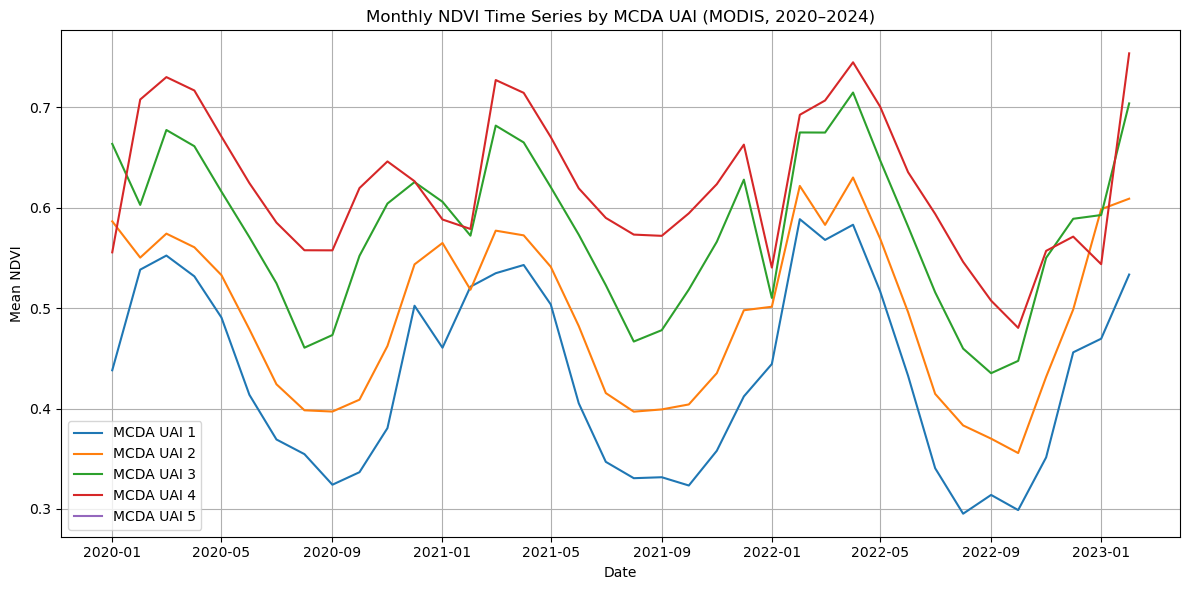

[MODIS] MCDA time series CSV exported: Bangweulu_MODIS_NDVI_TimeSeries_MCDA_UAIs.csv


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Define time range
months = pd.date_range('2020-01-01', '2024-12-31', freq='MS')
results_mcda = []

# Loop through each month and MCDA UAI zone
for date in months:
    start = date.strftime('%Y-%m-%d')
    end = (date + pd.DateOffset(months=1)).strftime('%Y-%m-%d')

    # Get monthly mean NDVI image
    monthly_coll = modisNDVI.filterDate(start, end)
    monthly_ndvi_img = monthly_coll.mean()

    try:
        band_names = monthly_ndvi_img.bandNames().getInfo()
        if 'NDVI' not in band_names:
            print(f"[MODIS] No NDVI band for {start} to {end}. Skipping.")
            continue
    except Exception as e:
        print(f"[MODIS] Band check failed for {start}: {e}. Skipping.")
        continue

    # Clip and select NDVI
    monthly_ndvi = monthly_ndvi_img.select('NDVI').clip(gma)

    for i in range(5):
        zone_mask = mcda_uai.eq(i + 1)
        masked_ndvi = monthly_ndvi.updateMask(zone_mask)

        try:
            stats = masked_ndvi.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=gma.geometry(),
                scale=250,
                maxPixels=1e13
            )
            ndvi_val = stats.get('NDVI').getInfo() if stats.get('NDVI') else None
        except Exception as e:
            print(f"[MODIS] Error retrieving NDVI for MCDA UAI {i+1} at {start}: {e}")
            ndvi_val = None

        results_mcda.append({'Date': start, 'UAI': f'MCDA UAI {i+1}', 'NDVI': ndvi_val})

# Convert to DataFrame
df_mcda = pd.DataFrame(results_mcda)
df_mcda['Date'] = pd.to_datetime(df_mcda['Date'])

# Plot NDVI time series for each MCDA UAI
plt.figure(figsize=(12, 6))
for uai in df_mcda['UAI'].unique():
    subset = df_mcda[df_mcda['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)

plt.title('Monthly NDVI Time Series by MCDA UAI (MODIS, 2020–2024)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Export to CSV
csv_path_mcda = f"{gma_name.replace(' ', '_')}_MODIS_NDVI_TimeSeries_MCDA_UAIs.csv"
df_mcda.to_csv(csv_path_mcda, index=False)
print(f"[MODIS] MCDA time series CSV exported: {csv_path_mcda}")

[VIIRS] No NDVI band for 2024-06-01 to 2024-07-01. Skipping.
[VIIRS] No NDVI band for 2024-07-01 to 2024-08-01. Skipping.
[VIIRS] No NDVI band for 2024-08-01 to 2024-09-01. Skipping.
[VIIRS] No NDVI band for 2024-09-01 to 2024-10-01. Skipping.
[VIIRS] No NDVI band for 2024-10-01 to 2024-11-01. Skipping.
[VIIRS] No NDVI band for 2024-11-01 to 2024-12-01. Skipping.
[VIIRS] No NDVI band for 2024-12-01 to 2025-01-01. Skipping.


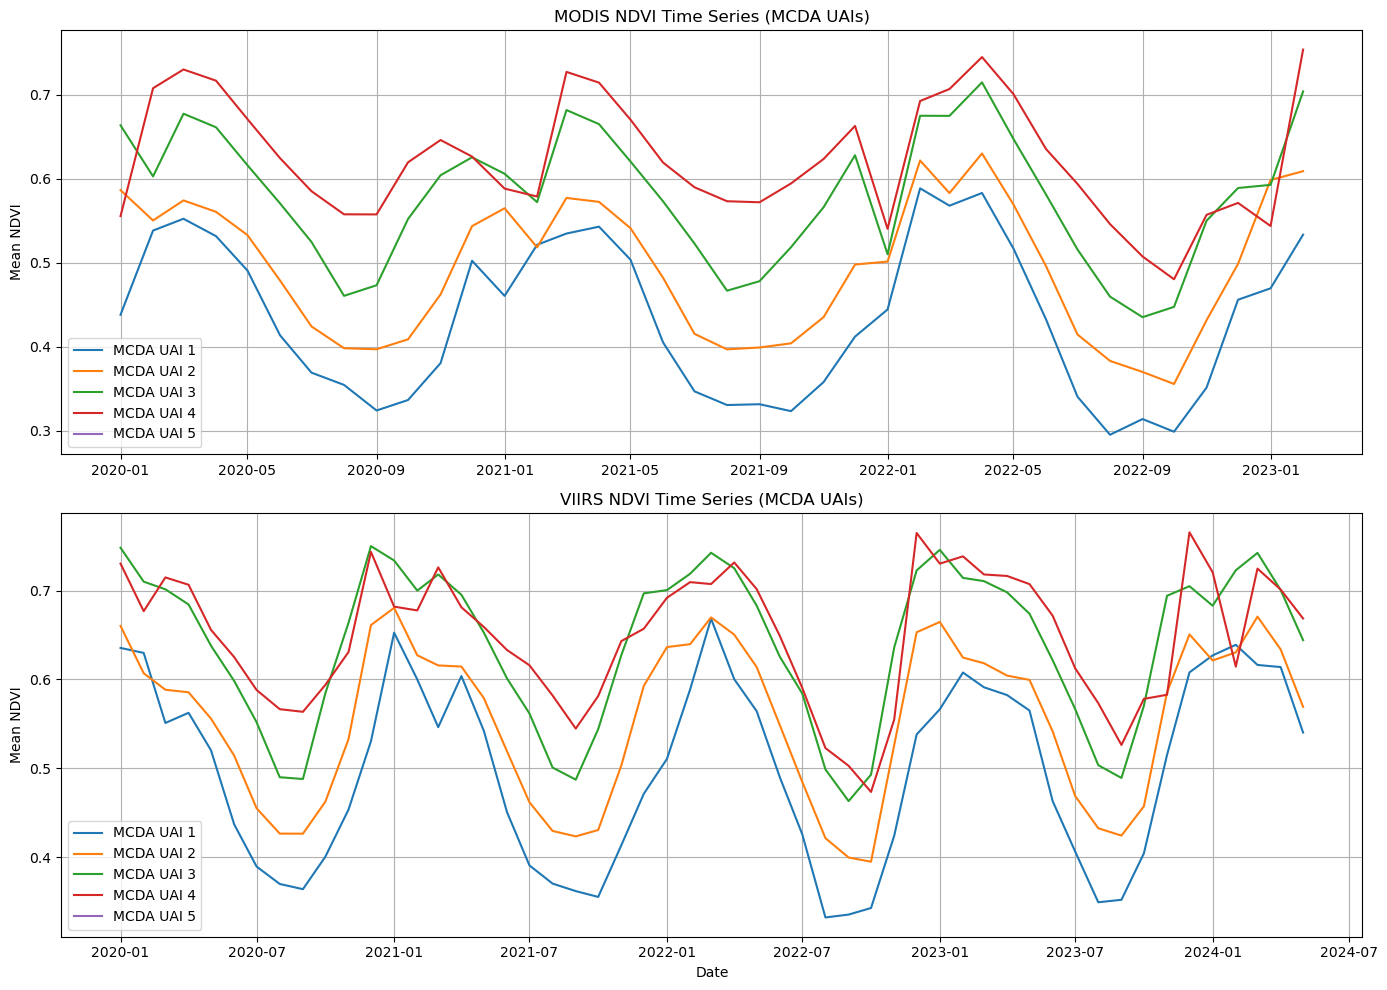

[VIIRS] MCDA time series CSV exported: Bangweulu_VIIRS_NDVI_TimeSeries_MCDA_UAIs.csv


In [23]:
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
    .filterDate('2020-01-01', '2024-12-31') \
    .filterBounds(gma) \
    .select('NDVI')

viirs_scale_factor = 0.0001
results_viirs_mcda = []

for date in months:
    start = date.strftime('%Y-%m-%d')
    end = (date + pd.DateOffset(months=1)).strftime('%Y-%m-%d')

    monthly_coll = viirs.filterDate(start, end)
    monthly_ndvi_img = monthly_coll.mean()

    try:
        band_names = monthly_ndvi_img.bandNames().getInfo()
        if 'NDVI' not in band_names:
            print(f"[VIIRS] No NDVI band for {start} to {end}. Skipping.")
            continue
    except Exception as e:
        print(f"[VIIRS] Band check failed for {start}: {e}. Skipping.")
        continue

    monthly_ndvi = monthly_ndvi_img.select('NDVI').multiply(viirs_scale_factor).clip(gma)

    for i in range(5):
        zone_mask = mcda_uai.eq(i + 1)
        masked_ndvi = monthly_ndvi.updateMask(zone_mask)

        try:
            stats = masked_ndvi.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=gma.geometry(),
                scale=500,
                maxPixels=1e13
            )
            ndvi_val = stats.get('NDVI').getInfo() if stats.get('NDVI') else None
        except Exception as e:
            print(f"[VIIRS] Error for MCDA UAI {i+1} at {start}: {e}")
            ndvi_val = None

        results_viirs_mcda.append({'Date': start, 'UAI': f'MCDA UAI {i+1}', 'NDVI': ndvi_val})

# Convert to DataFrame
df_viirs_mcda = pd.DataFrame(results_viirs_mcda)
df_viirs_mcda['Date'] = pd.to_datetime(df_viirs_mcda['Date'])

# Plot MODIS vs VIIRS time series
plt.figure(figsize=(14, 10))

# MODIS
plt.subplot(2, 1, 1)
for uai in df_mcda['UAI'].unique():
    subset = df_mcda[df_mcda['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)
plt.title('MODIS NDVI Time Series (MCDA UAIs)')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.legend()

# VIIRS
plt.subplot(2, 1, 2)
for uai in df_viirs_mcda['UAI'].unique():
    subset = df_viirs_mcda[df_viirs_mcda['UAI'] == uai]
    plt.plot(subset['Date'], subset['NDVI'], label=uai)
plt.title('VIIRS NDVI Time Series (MCDA UAIs)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Export VIIRS results to CSV
viirs_csv_path_mcda = f"{gma_name.replace(' ', '_')}_VIIRS_NDVI_TimeSeries_MCDA_UAIs.csv"
df_viirs_mcda.to_csv(viirs_csv_path_mcda, index=False)
print(f"[VIIRS] MCDA time series CSV exported: {viirs_csv_path_mcda}")

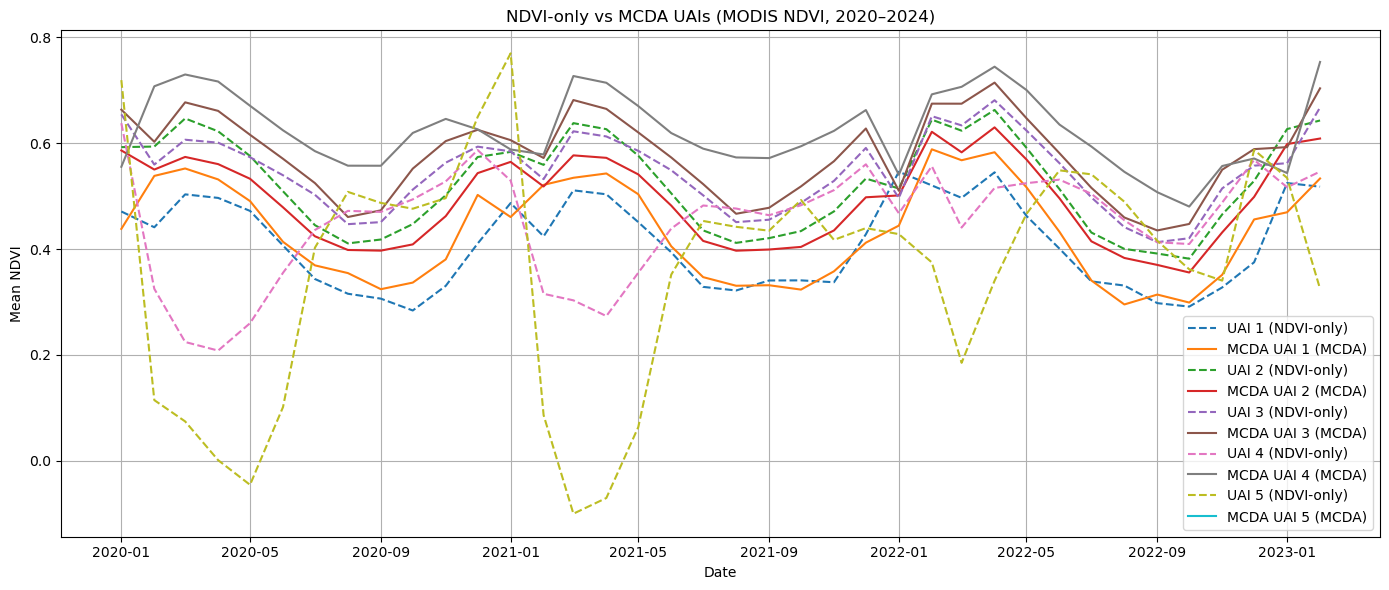

[Comparison] NDVI-only vs MCDA time series exported: Bangweulu_NDVI_Comparison_NDVI_vs_MCDA.csv


In [25]:
plt.figure(figsize=(14, 6))

for i in range(5):
    ndvi_only_label = f'UAI {i+1}'
    mcda_label = f'MCDA UAI {i+1}'

    # Extract MODIS NDVI-only UAI time series (from 1.8)
    subset_ndvi = df[df['UAI'] == ndvi_only_label]
    
    # Extract MODIS MCDA UAI time series (from 2.3)
    subset_mcda = df_mcda[df_mcda['UAI'] == mcda_label]

    # Plot both
    plt.plot(subset_ndvi['Date'], subset_ndvi['NDVI'], label=f'{ndvi_only_label} (NDVI-only)', linestyle='--')
    plt.plot(subset_mcda['Date'], subset_mcda['NDVI'], label=f'{mcda_label} (MCDA)', linestyle='-')

plt.title("NDVI-only vs MCDA UAIs (MODIS NDVI, 2020–2024)")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [28]:
# For vectorization, convert the continuous edible and non_edible_vegetation to a binary image.
# Here, we threshold > 0; adjust this threshold if needed.
edible_veg = edible_vegetation.gt(0).selfMask()
non_edible_veg = non_edible.gt(0).selfMask()

# Export function for masks (TIFF export)
def export_mask_to_tiff(mask, name):
    task = ee.batch.Export.image.toDrive(
        image=mask,
        description=f"{name}",
        folder="GMAs",
        fileNamePrefix=name,
        region=gma.geometry(),  # Area of interest
        scale=10,
        crs="EPSG:4326",  # or match your preferred CRS
        maxPixels=1e13,
        fileFormat="GeoTIFF"
    )
    task.start()
    print(f"Export task started for {name}. Check Google Drive for TIFF file.")

# Export masks
export_mask_to_tiff(water, f"{gma_name}_water_bodies")
export_mask_to_tiff(human, f"{gma_name}_human_activity")
export_mask_to_tiff(evergreen, f"{gma_name}_evergreen_vegetation")
export_mask_to_tiff(wetlands, f"{gma_name}_wetlands")
export_mask_to_tiff(edible_veg, f"{gma_name}_edible_vegetation")
export_mask_to_tiff(non_edible_veg, f"{gma_name}_non_edible_vegetation")
export_mask_to_tiff(uai_combined, f"{gma_name}_uai_segmentation")
export_mask_to_tiff(mcda_uai, f"{gma_name}_mcda_uai_segmentation")


print("All specified land cover masks are being exported as TIFFs.")

Export task started for Bangweulu_water_bodies. Check Google Drive for TIFF file.
Export task started for Bangweulu_human_activity. Check Google Drive for TIFF file.
Export task started for Bangweulu_evergreen_vegetation. Check Google Drive for TIFF file.
Export task started for Bangweulu_wetlands. Check Google Drive for TIFF file.
Export task started for Bangweulu_edible_vegetation. Check Google Drive for TIFF file.
Export task started for Bangweulu_non_edible_vegetation. Check Google Drive for TIFF file.
Export task started for Bangweulu_uai_segmentation. Check Google Drive for TIFF file.
Export task started for Bangweulu_mcda_uai_segmentation. Check Google Drive for TIFF file.
All specified land cover masks are being exported as TIFFs.


In [ ]:
import os
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import numpy as np
from shapely.geometry import shape

# === CONFIGURE INPUT AND OUTPUT FOLDERS ===
# Define input and output folders
# Get the current working directory
input_folder = os.getcwd()  # Dynamically set to the notebook's directory
output_folder = os.path.join(input_folder, "layer_shapefiles")  # Output within working directory

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# === PROCESS ALL TIF FILES ===
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".tif"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace(".tif", ".shp"))

        print(f"Processing {filename}...")

        with rasterio.open(input_path) as src:
            image = src.read(1)
            mask = image != src.nodata  # Exclude nodata pixels
            transform = src.transform
            crs = src.crs

        polygons = []
        values = []

        for geom, value in shapes(image, mask=mask, transform=transform):
            if value != 0:  # Optional: skip background/zero if needed
                polygons.append(shape(geom))
                values.append(value)

        if polygons:
            gdf = gpd.GeoDataFrame({'value': values, 'geometry': polygons}, crs=crs)
            gdf = gdf.dissolve()  # Merge all polygons into one feature
            gdf.to_file(output_path)
            print(f"Saved: {output_path}")
        else:
            print(f"No valid polygons found in {filename}.")

print("All raster files have been processed.")

Processing Bangweulu_edible_vegetation.tif...


In [30]:
import folium
import rasterio
import numpy as np
import geopandas as gpd
import branca
from folium import raster_layers

# Load shapefiles
gdf_boundary = gpd.read_file(f"{gma_name}.shp")
# gdf_clusters = gpd.read_file(f"{gma_name}_Edible_Vegetation_Clusters.shp")

# Load binary GeoTIFFs
tiff_layers = {
    "Water Bodies": f"{gma_name}_water_bodies.tif",
    "Human Activity": f"{gma_name}_human_activity.tif",
    "Wetlands": f"{gma_name}_wetlands.tif",
    "Edible Vegetation": f"{gma_name}_edible_vegetation.tif",
    "Non Edible Vegetation": f"{gma_name}_non_edible_vegetation.tif",
    "Evergreen Vegetation": f"{gma_name}_evergreen_vegetation.tif",  # optional
}

# Define multi-class layers
uai_layers = {
    "UAI Segmentation": f"{gma_name}_uai_segmentation.tif",
    "MCDA UAI Segmentation": f"{gma_name}_mcda_uai_segmentation.tif"
}

# Color settings for binary layers
color_map = {
    "Water Bodies": "#003df5",
    "Human Activity": "#800080",
    "Wetlands": "#87CEFA",
    "Edible Vegetation": "#7CFC00",
    "Non Edible Vegetation": "#F4A460",
    "Evergreen Vegetation": "#006400",
}

# Color settings for UAIs (multi-class)
uai_colormap = {
    1: "#ffffcc",  # Zone 1
    2: "#a1dab4",  # Zone 2
    3: "#41b6c4",  # Zone 3
    4: "#2c7fb8",  # Zone 4
    5: "#253494",  # Zone 5
}

# Center map
centroid = gdf_boundary.geometry.centroid.iloc[0]
latitude, longitude = centroid.y, centroid.x

m = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)

# Base layers
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add binary TIFF layer
def add_tiff_layer(filepath, layer_name, color_hex, map_object):
    with rasterio.open(filepath) as src:
        img = src.read(1)
        bounds = src.bounds

    mask = np.where(img == 1, 255, 0).astype(np.uint8)
    color_img = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    r, g, b = tuple(int(color_hex.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

    color_img[:, :, 0] = r
    color_img[:, :, 1] = g
    color_img[:, :, 2] = b
    color_img[:, :, 3] = mask

    raster = raster_layers.ImageOverlay(
        image=color_img,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        name=layer_name,
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )
    raster.add_to(map_object)

# Add multi-class TIFF layer
def add_multiclass_tiff(filepath, layer_name, class_colormap, map_object):
    with rasterio.open(filepath) as src:
        img = src.read(1)
        bounds = src.bounds

    height, width = img.shape
    rgba_img = np.zeros((height, width, 4), dtype=np.uint8)

    for class_val, color_hex in class_colormap.items():
        mask = img == class_val
        r, g, b = tuple(int(color_hex.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))
        rgba_img[mask, 0] = r
        rgba_img[mask, 1] = g
        rgba_img[mask, 2] = b
        rgba_img[mask, 3] = 255  # Fully visible

    raster = raster_layers.ImageOverlay(
        image=rgba_img,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        name=layer_name,
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )
    raster.add_to(map_object)

# Add all binary raster layers
for name, filepath in tiff_layers.items():
    add_tiff_layer(filepath, name, color_map[name], m)

# Add all UAI multi-class raster layers
for name, filepath in uai_layers.items():
    add_multiclass_tiff(filepath, name, uai_colormap, m)

# Add boundaries and clusters
folium.GeoJson(gdf_boundary, name=f"{gma_name} Boundary", style_function=lambda x: {
    "color": "black", "weight": 3, "fillOpacity": 0
}).add_to(m)

# folium.GeoJson(gdf_clusters, name="Edible Vegetation Clusters", style_function=lambda x: {
#     "color": "red", "weight": 1, "fillOpacity": 0
# }).add_to(m)

# Legend HTML
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: auto;
            background-color: white; z-index:9999; font-size:14px;
            border:1px solid black; padding: 10px;">
<b>Map Legend</b><br>
<span style="color:#003df5;">■</span> Water Bodies <br>
<span style="color:#800080;">■</span> Human Activity <br>
<span style="color:#006400;">■</span> Evergreen Vegetation <br>
<span style="color:#87CEFA;">■</span> Wetlands <br>
<span style="color:#7CFC00;">■</span> Edible Vegetation <br>
<span style="color:#F4A460;">■</span> Non Edible Vegetation <br>
<div style="display:inline-block; width:7px; height:7px; border:1px solid red; background:transparent; margin-right:2px;"></div> Edible Vegetation Clusters <br>
<b>UAI Zones</b><br>
<span style="color:#ffffcc;">■</span> Zone 1<br>
<span style="color:#a1dab4;">■</span> Zone 2<br>
<span style="color:#41b6c4;">■</span> Zone 3<br>
<span style="color:#2c7fb8;">■</span> Zone 4<br>
<span style="color:#253494;">■</span> Zone 5<br>
</div>
'''
m.get_root().html.add_child(branca.element.Element(legend_html))

# Final map controls
folium.LayerControl(collapsed=False).add_to(m)

# Save map
m.save(f"{gma_name}_Interactive_Map.html")
print(f"Interactive map for {gma_name} using GeoTIFF layers generated successfully.")


Interactive map for Bangweulu using GeoTIFF layers generated successfully.
